In [ ]:
import argparse
import pandas as pd
import numpy as np
import math
import h5py
from sklearn.model_selection import train_test_split
import joblib
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import sys
import gc

# import setGPU
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Concatenate, Dropout, Layer
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras import backend as K
tf.keras.mixed_precision.set_global_policy('mixed_float16')

from datetime import datetime
from tensorboard import program
import os
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
try:
    import mplhep as hep
    hep.style.use(hep.style.ROOT)
    print("Using MPL HEP for ROOT style formating")
except:
    print("Instal MPL HEP for style formating")
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#DB4437", "#4285F4", "#F4B400", "#0F9D58", "purple", "goldenrod", "peru", "coral","turquoise",'gray','navy','m','darkgreen','fuchsia','steelblue']) 
from autoencoder_classes import AE,VAE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from neptunecontrib.monitoring.keras import NeptuneMonitor
from losses import mse_split_loss, radius, kl_loss
from functions import make_mse_loss_numpy
from sklearn.metrics import roc_curve, auc


from data_preprocessing import prepare_data
from model import build_AE, build_VAE, Sampling


def return_total_loss(loss, bsm_t, bsm_pred):
    total_loss = loss(bsm_t, bsm_pred.astype(np.float32))
    return total_loss

In [2]:
####configuration####
input_qcd="/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended-v2/QCD_preprocessed.h5"
input_bsm="/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended-v2/BSM_preprocessed.h5"
events = 500000
load_pickle=False
input_pickle="data.pickle"
output_pfile="data.pickle"
output_model_h5='model.h5'
output_model_json='model.json'
output_history='history.h5'
output_result='results.h5'
model_type='VAE'
latent_dim=3
batch_size= 1024
#batch_size=512
#batch_size=256
n_epochs = 150

In [3]:
if(load_pickle):
    if(input_pickle==''):
        print('Please provide input pickle files')
    with open(input_pickle, 'rb') as f:
        X_train_flatten, X_train_scaled, X_test_flatten, X_test_scaled, bsm_data, bsm_target, pt_scaler, bsm_labels = pickle.load(f)
        bsm_labels=['VectorZPrimeToQQ__M50',
              'VectorZPrimeToQQ__M100',
              'VectorZPrimeToQQ__M200',
              'VBF_HToInvisible_M125',
              'VBF_HToInvisible_M125_private',
              'ZprimeToZH_MZprime1000',
              'ZprimeToZH_MZprime800',
              'ZprimeToZH_MZprime600',
              'GluGluToHHTo4B',
              'HTo2LongLivedTo4mu_1000',
              'HTo2LongLivedTo4mu_125_12',
              'HTo2LongLivedTo4mu_125_25',
              'HTo2LongLivedTo4mu_125_50',
              'VBFHToTauTau',
              'VBF_HH']
else:
    if(input_qcd==''or input_bsm==''):
        print('Please provide input H5 files')
    X_train_flatten, X_train_scaled, X_test_flatten, X_test_scaled, bsm_data, bsm_target, pt_scaler, bsm_labels = prepare_data(input_qcd, input_bsm, events, output_pfile,True)
    

*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data


In [4]:
if(model_type=='AE'):
    autoencoder = build_AE(X_train_flatten.shape[-1],latent_dim)
    model = AE(autoencoder)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001))

    callbacks=[]
    callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
    callbacks.append(TerminateOnNaN())
    callbacks.append(NeptuneMonitor())
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

elif(model_type=='VAE'):
    encoder, decoder = build_VAE(X_train_flatten.shape[-1],latent_dim)
    model = VAE(encoder, decoder)
    model.compile(optimizer=keras.optimizers.Adam())

    callbacks=[]
    callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
    callbacks.append(TerminateOnNaN())
    callbacks.append(NeptuneMonitor())
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

print("Training the model")

history = model.fit(X_train_flatten, X_train_scaled,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=callbacks)

del X_train_flatten, X_train_scaled


gc.collect()


2022-05-10 13:09:55.368905: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-10 13:10:04.376192: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10600 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:65:00.0, compute capability: 6.0


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 57)          228         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 dense (Dense)                  (None, 32)           1856        ['batch_normalization[0][0]']    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32)          128         ['dense[0][0]']            

196/196 [==============================] - 3s 15ms/step - loss: 0.2851 - reconstruction_loss: 0.2841 - kl_loss: 5.0904e-04 - val_loss: 0.2801 - val_reconstruction_loss: 0.2796 - val_kl_loss: 4.5210e-04 - lr: 1.0000e-04
Epoch 16/150
196/196 [==============================] - 3s 14ms/step - loss: 0.2836 - reconstruction_loss: 0.2841 - kl_loss: 5.2282e-04 - val_loss: 0.2801 - val_reconstruction_loss: 0.2797 - val_kl_loss: 4.5392e-04 - lr: 1.0000e-04
Epoch 17/150
195/196 [============================>.] - ETA: 0s - loss: 0.2840 - reconstruction_loss: 0.2840 - kl_loss: 5.0032e-04
Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
196/196 [==============================] - 3s 15ms/step - loss: 0.2841 - reconstruction_loss: 0.2840 - kl_loss: 5.0002e-04 - val_loss: 0.2802 - val_reconstruction_loss: 0.2798 - val_kl_loss: 4.5871e-04 - lr: 1.0000e-04
Epoch 18/150
196/196 [==============================] - 3s 15ms/step - loss: 0.2833 - reconstruction_loss: 0.2842 - kl

2099

saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Saved history to disk
        loss  reconstruction_loss   kl_loss  val_loss  \
29  0.284456             0.283915  0.000504  0.280043   
30  0.284433             0.283914  0.000501  0.280121   
31  0.284569             0.284077  0.000499  0.280186   
32  0.284438             0.283901  0.000502  0.280219   
33  0.284496             0.283962  0.000509  0.280118   

    val_reconstruction_loss  val_kl_loss        lr  epoch  
29                 0.279616     0.000436  0.000001     29  
30                 0.279696     0.000432  0.000001     30  
31                 0.279735     0.000460  0.000001     31  
32                 0.279768     0.000460  0.000001     32  
33                 0.279683     0.000443  0.000001     33  


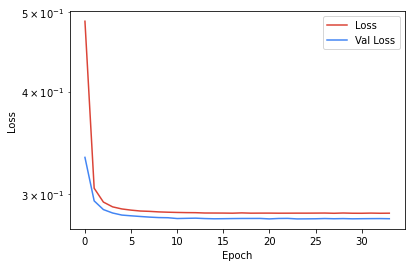

In [5]:
if(output_model_h5!=''):
    if(model_type=='VAE'):
        model.save(os.path.join(os.getcwd(),output_model_h5.split('.')[0]))
    else:
        model_json = autoencoder.to_json()
        with open(output_model_json, 'w') as json_file:
            json_file.write(model_json)
        autoencoder.save_weights(output_model_h5)
        print("Saved model to disk")


if(output_history!=''):
    with open(output_history, 'wb') as f:
        pickle.dump(history.history, f)
    print("Saved history to disk")



# Plot training & validation loss values
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail())
plt.plot(hist.index.to_numpy(),hist['loss'],label='Loss')
plt.plot(hist.index.to_numpy(),hist['val_loss'],label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.savefig('history.pdf')
# plt.show()

In [6]:
#load model
model_dir = output_model_h5.split('.')[0]
if(model_type=='AE'):
    with open(model_dir+"/model.json", 'r') as jsonfile: config = jsonfile.read()
    ae = tf.keras.models.model_from_json(config)    
    ae.load_weights(model_dir+"/model.h5")
    ae.summary()
    model = AE(ae)
elif(model_type=='VAE'):
    encoder, decoder = VAE.load(model_dir, custom_objects={'Sampling': Sampling})
    encoder.summary()
    decoder.summary()
    model = VAE(encoder, decoder)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 57)          228         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 dense (Dense)                  (None, 32)           1856        ['batch_normalization[0][0]']    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32)          128         ['dense[0][0]']            

In [7]:
from end2end import get_results
data_file = input_pickle
outdir = output_model_h5.split('.')[0]
if not load_pickle: data_file = output_pfile
results = get_results(input_qcd,input_bsm,data_file,outdir,events,model_type,latent_dim)

for key in results.keys():
    results[key]['loss'] = results[key]['loss'][np.isfinite(results[key]['loss'])]
    results[key]['total_loss'] = results[key]['total_loss'][np.isfinite(results[key]['total_loss'])]
    results[key]['radius'] = results[key]['radius'][np.isfinite(results[key]['radius'])]


Instal MPL HEP for style formating
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 57)          228         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 dense (Dense)                  (None, 32)           1856        ['batch_normalization[0][0]']    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32)          128 

In [8]:
min_loss,max_loss=1e5,0
if(model_type=='VAE'):
    min_tloss,max_tloss=1e5,0
    min_r,max_r=1e5,0
for key in results.keys():
    # if(key=='QCD'): continue
    if(np.min(results[key]['loss'])<min_loss): min_loss = np.min(results[key]['loss'])
    if(np.max(results[key]['loss'])>max_loss): max_loss = np.max(results[key]['loss'])
    if(model_type=='VAE'):
        if(np.min(results[key]['total_loss'])<min_tloss): min_tloss = np.min(results[key]['total_loss'])
        if(np.max(results[key]['total_loss'])>max_tloss): max_tloss = np.max(results[key]['total_loss'])
        # if(max_tloss>np.mean(results[key]['total_loss'])+10*np.std(results[key]['total_loss'])): max_tloss = np.mean(results[key]['total_loss'])+10*np.std(results[key]['total_loss'])
        print(key,"Total_loss",np.mean(results[key]['total_loss'])+10*np.std(results[key]['total_loss']))
        if(np.min(results[key]['radius'])<min_r): min_r = np.min(results[key]['radius'])
        if(np.max(results[key]['radius'])>max_r): max_r = np.max(results[key]['radius'])
        # if(max_r>np.mean(results[key]['radius'])+10*np.std(results[key]['radius'])): max_r = np.mean(results[key]['radius'])+10*np.std(results[key]['radius'])
        print(key,"radius",np.mean(results[key]['radius'])+10*np.std(results[key]['radius']))
print(min_loss,max_loss)
print(min_tloss,max_tloss)
print(min_r,max_r)

GluGluToHHTo4B Total_loss 46.861844301223755
GluGluToHHTo4B radius 2576.3334082365036
HTo2LongLivedTo4mu_1000 Total_loss 1277160409984.0
HTo2LongLivedTo4mu_1000 radius 136048137776.0
HTo2LongLivedTo4mu_125_12 Total_loss 10655.959005355835
HTo2LongLivedTo4mu_125_12 radius 616303038.5625
HTo2LongLivedTo4mu_125_25 Total_loss 828133.5537109375
HTo2LongLivedTo4mu_125_25 radius 85820371880.0
HTo2LongLivedTo4mu_125_50 Total_loss 124004.1720199585
HTo2LongLivedTo4mu_125_50 radius 5161086314.5
VBFHToTauTau Total_loss 25.06710934638977
VBFHToTauTau radius 2881.9967209100723
VBF_HH Total_loss 21.50553250312805
VBF_HH radius 72.60161979496479
VBF_HToInvisible_M125 Total_loss 8.655685544013977
VBF_HToInvisible_M125 radius 1.5977637046016753
VBF_HToInvisible_M125_private Total_loss 8.699499249458313
VBF_HToInvisible_M125_private radius 0.16772360203322023
VectorZPrimeToQQ__M100 Total_loss 19.630937337875366
VectorZPrimeToQQ__M100 radius 3.7170722279697657
VectorZPrimeToQQ__M200 Total_loss 20.2671070

Plotting the results


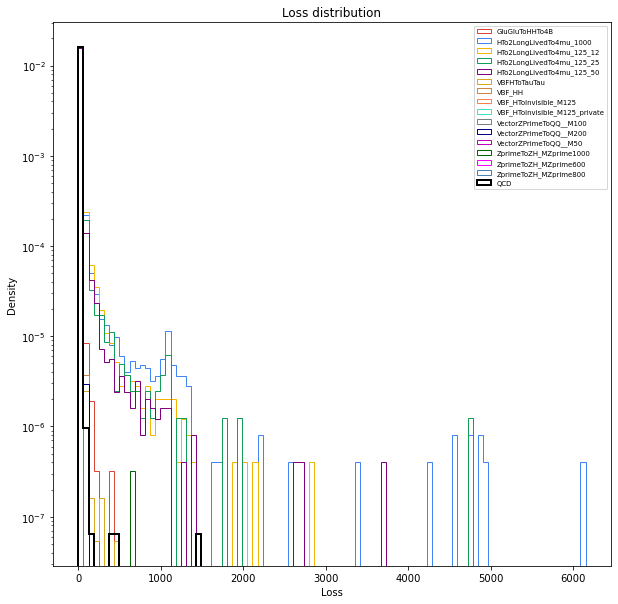

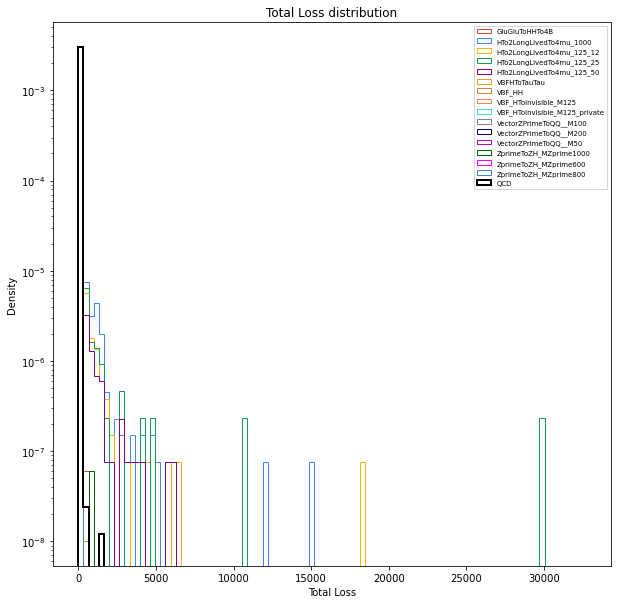

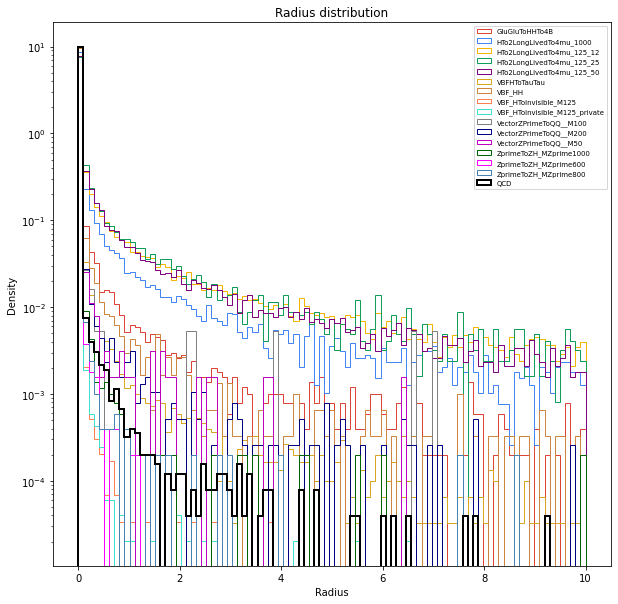

In [9]:
tag='vtest'
print("Plotting the results")
bins_=np.linspace(min_loss,max_loss,100)
plt.figure(figsize=(10,10))
for key in results.keys():
    if(key=='QCD'): plt.hist(results[key]['loss'],label=key,histtype='step',bins=bins_,color='black',linewidth=2,density=True)
    else: plt.hist(results[key]['loss'],label=key,histtype='step',bins=bins_,density=True)
plt.legend(fontsize='x-small')
plt.yscale('log')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('Loss distribution')
plt.savefig('loss_hist_'+model_type+'_'+tag+'.pdf')
# plt.show()

if(model_type=='VAE'):

    bins_=np.linspace(min_tloss,32673,100)
    plt.figure(figsize=(10,10))
    for key in results.keys():
        if(key=='QCD'): plt.hist(results[key]['total_loss'],label=key,histtype='step',bins=bins_,color='black',linewidth=2,density=True)
        else: plt.hist(results[key]['total_loss'],label=key,histtype='step',bins=bins_,density=True)
    plt.legend(fontsize='x-small')
    plt.yscale('log')
    plt.xlabel('Total Loss')
    plt.ylabel('Density')
    plt.title('Total Loss distribution')
    plt.savefig('total_loss_hist_'+model_type+'_'+tag+'.pdf')

    bins_=np.linspace(min_r,10,100)
    plt.figure(figsize=(10,10))
    for key in results.keys():
        if(key=='QCD'): plt.hist(results[key]['radius'],label=key,histtype='step',bins=bins_,color='black',linewidth=2,density=True)
        else: plt.hist(results[key]['radius'],label=key,histtype='step',bins=bins_,density=True)
    plt.legend(fontsize='x-small')
    plt.yscale('log')
    plt.xlabel('Radius')
    plt.ylabel('Density')
    plt.title('Radius distribution')
    plt.savefig('radius_hist_'+model_type+'_'+tag+'.pdf')
    
#     for key in results.keys():
#         plt.figure(figsize=(10,10))
#         for i in range(latent_dim):
#             plt.hist(results[key]['mean_prediction'][:,i],bins=100,label='mean '+str(i),histtype='step', density=True,range=[-5,5])
#         plt.legend(fontsize='x-small')
#         plt.xlabel('Loss')
#         plt.ylabel('z')
#         plt.title(key+' mean Z distribution')
#         plt.savefig('mean_z_'+model_type+'_'+key+'_'+tag+'.pdf')
#         # plt.show()

#     for key in results.keys():
#         plt.figure(figsize=(10,10))
#         for i in range(latent_dim):
#             plt.hist(results[key]['logvar_prediction'][:,i],bins=100,label='logvar '+str(i),histtype='step', density=True,range=[-20,20])
#         plt.legend(fontsize='x-small')
#         plt.xlabel('Loss')
#         plt.ylabel('z')
#         plt.title(key+' logvar Z distribution')
#         plt.savefig('logvar_z_'+model_type+'_'+key+'_'+tag+'.pdf')
#         # plt.show()


In [ ]:
tag='vtest'

signal_eff={}

plt.figure(figsize=(10,10))
for key in results.keys():
    if key=='QCD': continue
    signal_eff[key]={}
    true_label = np.concatenate(( np.ones(results[key]['loss'].shape[0]), np.zeros(results['QCD']['loss'].shape[0]) ))
    pred_loss = np.concatenate(( results[key]['loss'], results['QCD']['loss'] ))
    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)
    signal_eff[key]['MSE_loss']=tpr_loss[fpr_loss<0.000125][-1]

    auc_loss = auc(fpr_loss, tpr_loss)
    plt.plot(fpr_loss, tpr_loss, label='%s (AUC = %0.2f)' %(key,auc_loss))
plt.legend(fontsize='x-small')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1)
plt.title('ROC curve '+model_type)
plt.xscale('log')
plt.yscale('log')
plt.savefig('roc_curve_'+model_type+'_'+tag+'.pdf')
# plt.show()

if(model_type=='VAE'):
    plt.figure(figsize=(10,10))
    for key in results.keys():
        if key=='QCD': continue

        true_label = np.concatenate(( np.ones(results[key]['total_loss'].shape[0]), np.zeros(results['QCD']['total_loss'].shape[0]) ))
        #print('true_label is ', true_label)
        pred_loss = np.concatenate(( results[key]['total_loss'], results['QCD']['total_loss'] ))
        fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)
        print(fpr_loss)
        signal_eff[key]['KL_loss']=tpr_loss[fpr_loss<0.000125][-1]

        auc_loss = auc(fpr_loss, tpr_loss)
        plt.plot(fpr_loss, tpr_loss, label='%s (AUC = %0.2f)' %(key,auc_loss))
    plt.legend(fontsize='x-small')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
    plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1)
    plt.title('Total Loss ROC curve '+model_type)
    plt.xscale('log')
    plt.yscale('log')
    plt.savefig('roc_curve_'+model_type+'_'+tag+'.pdf')
    # plt.show()

    plt.figure(figsize=(10,10))
    for key in results.keys():
        if key=='QCD': continue

        true_label = np.concatenate(( np.ones(results[key]['radius'].shape[0]), np.zeros(results['QCD']['radius'].shape[0]) ))
        pred_loss = np.concatenate(( results[key]['radius'], results['QCD']['radius'] ))
        fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)
        signal_eff[key]['radius']=tpr_loss[fpr_loss<0.000125][-1]
        
        
        auc_loss = auc(fpr_loss, tpr_loss)
        plt.plot(fpr_loss, tpr_loss, label='%s (AUC = %0.2f)' %(key,auc_loss))
    plt.legend(fontsize='x-small')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
    plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1)
    plt.title('Radius ROC curve '+model_type)
    plt.xscale('log')
    plt.yscale('log')
    plt.savefig('roc_curve_'+model_type+'_'+tag+'.pdf')
    # plt.show()
    
signal_eff_pd = pd.DataFrame.from_dict(signal_eff).transpose()
print('Efficiency is ', tpr_loss[fpr_loss<0.000125][-1])
print('AUC_loss is ', auc_loss)

In [20]:
x = np.random.uniform(low=-1, high=1.0, size=(1,57))
y = encoder.predict(x)
print(y)

[array([[-0.0892 ,  0.06775, -0.0397 ]], dtype=float16), array([[ 0.0484 , -0.02243, -0.02176]], dtype=float16), array([[-0.24546601,  2.2040746 , -1.4615848 ]], dtype=float32)]


In [23]:
a = model.predict(x)

NotImplementedError: in user code:

    File "/uscms_data/d3/tphan/miniforge3/envs/l1ad/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/uscms_data/d3/tphan/miniforge3/envs/l1ad/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/uscms_data/d3/tphan/miniforge3/envs/l1ad/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/uscms_data/d3/tphan/miniforge3/envs/l1ad/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/uscms_data/d3/tphan/miniforge3/envs/l1ad/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/uscms_data/d3/tphan/miniforge3/envs/l1ad/lib/python3.9/site-packages/keras/engine/training.py", line 475, in call
        raise NotImplementedError('When subclassing the `Model` class, you should '

    NotImplementedError: Exception encountered when calling layer "vae_1" (type VAE).
    
    When subclassing the `Model` class, you should implement a `call()` method.
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, None), dtype=float16)
      • training=False
      • mask=None
